Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data prostate
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/prostate_TumorVSNormal_test.data"
url_train = "https://raw.githubusercontent.com/jamessaldo/final-task/master/prostate_TumorVSNormal_train.data"
data_train = pd.read_csv(url_train, header=None)
data_test = pd.read_csv(url_test, header=None)
data_prostate = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada data prostate tumor:',data_prostate.isnull().sum().sum())

Total Missing Value pada data prostate tumor: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data prostate
data_new_prostate = data_prostate.drop([12600],axis=1)
scaler = MinMaxScaler()
data_new_prostate = scaler.fit_transform(data_new_prostate)
data_new_prostate = DataFrame(data_new_prostate)
data_new_prostate['label'] = list(data_prostate[12600])
dic = {'Normal':0,'Tumor':1}
data_new_prostate.replace(dic,inplace=True)

# 2. Define Reusable Function

## FLNN Classifier

In [5]:
def FLNN_Classifier(data_train, data_test, orde, lr):
    start = timeit.default_timer()
    
    x_data_train = data_train.drop(['label'],axis=1)
    y_data_train = data_train['label']
    x_data_test = data_test.drop(['label'],axis=1)
    y_data_test = data_test['label']
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for x in range(1, orde+1):
        pn = legendre(x)
        y_orde = pn(x_data_train)
        df_train = pd.concat([df_train, y_orde], axis=1)
        
        pn = legendre(x)
        y_orde = pn(x_data_test)
        df_test = pd.concat([df_test, y_orde], axis=1)

    df_train.columns = ["Attribut"+str(i) for i in range(len(df_train.columns))]
    df_train['label'] = y_data_train.reset_index().label
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1].values
    y_train = df_train.iloc[:, len(df_train.columns)-1].values
    
    df_test.columns = ["Attribut"+str(i) for i in range(len(df_test.columns))]
    df_test['label'] = y_data_test.reset_index().label
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1].values
    y_test = df_test.iloc[:, len(df_test.columns)-1].values

    # Melakukan proses klasifikasi FLNN
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_train.columns)-1, kernel_initializer = 'uniform', input_dim = len(df_train.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=lr), loss = 'mean_squared_error', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    akurasi = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')

    print("Akurasi : ", akurasi)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

    stop = timeit.default_timer()
    print('Running Time: ', stop - start) 
    return akurasi, F1, stop-start

# 3. Classification

Train :  [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test :  [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
prostate + IG Orde 2 v1
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  0.42857142857142855
F1_Score :  0.3
              precision    recall  f1-score   support

      

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: Undefin

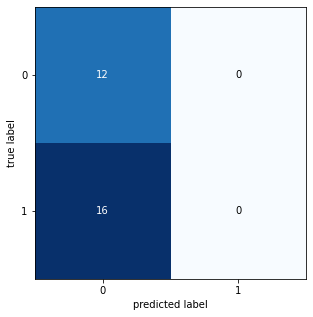

Running Time:  404.5759782
prostate + IG Orde 3 v1


KeyboardInterrupt: 

In [6]:
start = timeit.default_timer()
akurasi_IG_2_v1,f1_IG_2_v1,rt_IG_2_v1 = [],[],[]
akurasi_IG_3_v1,f1_IG_3_v1,rt_IG_3_v1 = [],[],[]
akurasi_IG_4_v1,f1_IG_4_v1,rt_IG_4_v1 = [],[],[]

akurasi_IG_2_v2,f1_IG_2_v2,rt_IG_2_v2 = [],[],[]
akurasi_IG_3_v2,f1_IG_3_v2,rt_IG_3_v2 = [],[],[]
akurasi_IG_4_v2,f1_IG_4_v2,rt_IG_4_v2 = [],[],[]

#Melakukan proses K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
kf.get_n_splits(data_new_prostate)
X = data_new_prostate.copy().iloc[:, 0:len(data_new_prostate.columns)-1].values
Y = data_new_prostate.copy().iloc[:, len(data_new_prostate.columns)-1].values
for train_index, test_index in kf.split(X,Y):
    print("Train : ", train_index, "Test : ", test_index)
    data_train, data_test, y_train, y_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index]), Y[train_index], Y[test_index]
    data_train['label'] = y_train
    data_test['label'] = y_test
    
    print("prostate Orde 2 v1")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), 2, 0.6)
    akurasi_IG_2_v1.append(acc)
    f1_IG_2_v1.append(f1)
    rt_IG_2_v1.append(rt)
    print("prostate Orde 3 v1")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), 3, 0.6)
    akurasi_IG_3_v1.append(acc)
    f1_IG_3_v1.append(f1)
    rt_IG_3_v1.append(rt)
    print("prostate Orde 4 v1")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), 4, 0.6)
    akurasi_IG_4_v1.append(acc)
    f1_IG_4_v1.append(f1)
    rt_IG_4_v1.append(rt)
    
    print("prostate Orde 2 v2")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), 2, 0.001)
    akurasi_IG_2_v2.append(acc)
    f1_IG_2_v2.append(f1)
    rt_IG_2_v2.append(rt)
    print("prostate Orde 3 v2")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), 3, 0.001)
    akurasi_IG_3_v2.append(acc)
    f1_IG_3_v2.append(f1)
    rt_IG_3_v2.append(rt)
    print("prostate Orde 4 v1")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), 4, 0.001)
    akurasi_IG_4_v2.append(acc)
    f1_IG_4_v2.append(f1)
    rt_IG_4_v2.append(rt)
    
akurasi_IG_2_v1,f1_IG_2_v1,rt_IG_2_v1 = np.array(akurasi_IG_2_v1),np.array(f1_IG_2_v1),np.array(rt_IG_2_v1)
akurasi_IG_3_v1,f1_IG_3_v1,rt_IG_3_v1 = np.array(akurasi_IG_3_v1),np.array(f1_IG_3_v1),np.array(rt_IG_3_v1)
akurasi_IG_4_v1,f1_IG_4_v1,rt_IG_4_v1 = np.array(akurasi_IG_4_v1),np.array(f1_IG_4_v1),np.array(rt_IG_4_v1)

akurasi_IG_2_v2,f1_IG_2_v2,rt_IG_2_v2 = np.array(akurasi_IG_2_v2),np.array(f1_IG_2_v2),np.array(rt_IG_2_v2)
akurasi_IG_3_v2,f1_IG_3_v2,rt_IG_3_v2 = np.array(akurasi_IG_3_v2),np.array(f1_IG_3_v2),np.array(rt_IG_3_v2)
akurasi_IG_4_v2,f1_IG_4_v2,rt_IG_4_v2 = np.array(akurasi_IG_4_v2),np.array(f1_IG_4_v2),np.array(rt_IG_4_v2)


#Print Result
print('===============================================================================================================================================================================================================')
print('Avg accuracy prostate cancer orde 2 v1 : ', akurasi_IG_2_v1.mean())
print('Avg F1 score prostate cancer orde 2 v1 : ', f1_IG_2_v1.mean())
print('Avg running time prostate cancer orde 2 v1 : ', rt_IG_2_v1.mean())
print('Avg accuracy prostate cancer orde 3 v1 : ', akurasi_IG_3_v1.mean())
print('Avg F1 score prostate cancer orde 3 v1 : ', f1_IG_3_v1.mean())
print('Avg running time prostate cancer orde 3 v1 : ', rt_IG_3_v1.mean())
print('Avg accuracy prostate cancer orde 4 v1 : ', akurasi_IG_4_v1.mean())
print('Avg F1 score prostate cancer orde 4 v1 : ', f1_IG_4_v1.mean())
print('Avg running time prostate cancer orde 4 v1 : ', rt_IG_4_v1.mean())
print('===============================================================================================================================================================================================================')
print('Avg accuracy prostate cancer orde 2 v2 : ', akurasi_IG_2_v2.mean())
print('Avg F1 score prostate cancer orde 2 v2 : ', f1_IG_2_v2.mean())
print('Avg running time prostate cancer orde 2 v2 : ', rt_IG_2_v2.mean())
print('Avg accuracy prostate cancer orde 3 v2 : ', akurasi_IG_3_v2.mean())
print('Avg F1 score prostate cancer orde 3 v2 : ', f1_IG_3_v2.mean())
print('Avg running time prostate cancer orde 3 v2 : ', rt_IG_3_v2.mean())
print('Avg accuracy prostate cancer orde 4 v2 : ', akurasi_IG_4_v2.mean())
print('Avg F1 score prostate cancer orde 4 v2 : ', f1_IG_4_v2.mean())
print('Avg running time prostate cancer orde 4 v2 : ', rt_IG_4_v2.mean())
print()
stop = timeit.default_timer()
print("Overall Running Time : ", stop-start)